# **Multivariate LSTM Models**

When talking about Multivariate Models, we are taking into consideration some predictors, independent variables that we can take advantage from when predicting our target variable.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
#Now, we import the dataset
df = pd.read_csv('Electricity+Consumption.csv')

In [35]:
df.head()

,DATE,Humidity,Temperature,Electricity
0,2020-01-01 00:00:00 EST,92,-1.1,914
1,2020-01-01 01:00:00 EST,92,-1.5,887
2,2020-01-01 02:00:00 EST,91,-1.5,865
3,2020-01-01 03:00:00 EST,88,-1.1,852
4,2020-01-01 04:00:00 EST,87,-1.3,852


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE         8760 non-null   object 
 1   Humidity     8760 non-null   int64  
 2   Temperature  8760 non-null   float64
 3   Electricity  8760 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 273.9+ KB


We have a dataset with 8,760 rows and 4 dimensions. The first column is the date, which is not needed at all for the model itself, is more for our information.

**What's our goal?** Predict the future evolution of electricty consumption.

In [37]:
#Despite not having any null values, we will use dropna() because it is a good practice
df.dropna(inplace=True)

<Axes: >

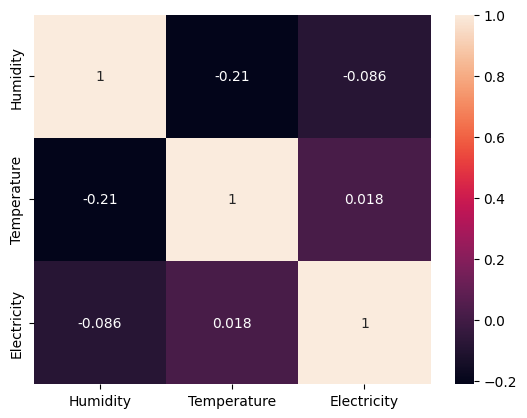

In [38]:
import seaborn as sns

#Exclude the 'DATE' column from the DataFrame before computing the correlation matrix
corr_df = df.drop(columns=['DATE'])

sns.heatmap(corr_df.corr(), annot=True)

We can see that the correlation is not too strong, but let's hope that it can help our model to learn better

In [39]:
#Now, we will split the dataset into training and testing sets
training_set = df.iloc[:8712, 1:4].values #As we said, column DATE is not important, so we exclude it and include the other 3 columns. We are getting 8712 rows in train, and the rest (48) in test
test_set = df.iloc[8712:, 1:4].values

In [40]:
training_set

array([[  92. ,   -1.1,  914. ],
       [  92. ,   -1.5,  887. ],
       [  91. ,   -1.5,  865. ],
       ...,
       [  82. ,   -2.4, 1086. ],
       [  82. ,   -3.1, 1034. ],
       [  73. ,   -5. ,  979. ]])

In [41]:
#Now, we have to normalize our data. This was optional when dealing with just one variable but for multiple variables, it is a must. 
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))

training_set_scaled = sc.fit_transform(training_set)
test_set_scaled = sc.fit_transform(test_set)

In [42]:
training_set_scaled

array([[0.91011236, 0.4       , 0.27878788],
       [0.91011236, 0.3936    , 0.25541126],
       [0.8988764 , 0.3936    , 0.23636364],
       ...,
       [0.79775281, 0.3792    , 0.42770563],
       [0.79775281, 0.368     , 0.38268398],
       [0.69662921, 0.3376    , 0.33506494]])

In [43]:
#We have to modify our test_set scaled, as we want to exclude from it the column to predict (the last one in this case). We just want the predictors, the independent variables
test_set_scaled = test_set_scaled[:,0:2]

In [44]:
test_set_scaled

array([[0.61702128, 0.375     ],
       [0.70212766, 0.30555556],
       [0.68085106, 0.22222222],
       [0.65957447, 0.1875    ],
       [0.65957447, 0.15972222],
       [0.68085106, 0.125     ],
       [0.63829787, 0.08333333],
       [0.63829787, 0.02777778],
       [0.63829787, 0.        ],
       [0.61702128, 0.04166667],
       [0.53191489, 0.09722222],
       [0.46808511, 0.15972222],
       [0.31914894, 0.22222222],
       [0.21276596, 0.28472222],
       [0.14893617, 0.29861111],
       [0.        , 0.34027778],
       [0.04255319, 0.3125    ],
       [0.21276596, 0.21527778],
       [0.27659574, 0.21527778],
       [0.44680851, 0.125     ],
       [0.44680851, 0.13194444],
       [0.53191489, 0.20138889],
       [0.57446809, 0.19444444],
       [0.5106383 , 0.22222222],
       [0.55319149, 0.22916667],
       [0.59574468, 0.20833333],
       [0.59574468, 0.22916667],
       [0.63829787, 0.22916667],
       [0.70212766, 0.23611111],
       [0.72340426, 0.24305556],
       [0.

Now, we want to create different batches. The code will be equal than in the LSTM_Univariate_Training notebook. The only thing we have to change here is the WS parameter, which will depend on the specific case. Also, we modify a bit the dimensions when creating the loop

In [45]:
#We need to create empty lists as we are going to use for loop to append the values
X_train = []
y_train = []

#We select windows size as 24, as we have 24 hours seasonality
WS = 24

In [46]:
#Now, we create the for loop for creating our X_train and y_train
for i in range(WS, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-WS:i,0:3]) #We are using the append method and we are saying, go to training_set_scaled and select the values from i-WS to i, and select all the columns, included the predictors. With that, we would have different batches of 24, 24... So, first batch is the first 24 hours, then the second batch is from 1 to 25, and so on.
    y_train.append(training_set_scaled[i,2]) #For the y_train we are doing pretty much the same thing but we are just selecting the next value, so if first batch covers from 0 to 23, the y_train will be 24, and so on. Here, we select just the column including the target variable.

#Finally we have to convert the X_train and y_train into numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

In [47]:
#Finally we have to convert the X_train and y_train into numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

In [48]:
X_train.shape

(8688, 24, 3)

We can see that now we have 24 features

In [49]:
#The last stage is reshaping to make sure that everything is in the proper state previously sending it to our model
X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1], 3)) #Last number is the number of features that are going into our model, in this case 3

In [50]:
X_train.shape

(8688, 24, 3)

In this case, nothing has changed in the shape, but it is a good exercise to be hundred per cent sure that we are doing the right thing

# 2. LSTM Model

In [51]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [52]:
#First, we initialize our model
Model = Sequential()

In [53]:
#Now, we are going to add the first LSTM layer
Model.add(LSTM(units=70, return_sequences=True, input_shape=(X_train.shape[1], 3))) #Input shape is our input layer. We have 3 because number of features is 3.
Model.add(Dropout(0.2)) #We are going to use dropout regularization to avoid overfitting

In [54]:
#Now, let's add the second layer. At this point, we don't need input_shape
Model.add(LSTM(units=70, return_sequences=True))
Model.add(Dropout(0.2))

In [55]:
#We add the third layer
Model.add(LSTM(units=70, return_sequences=True))
Model.add(Dropout(0.2))

In [56]:
#We add the last hidden layer. We don't need return_sequences=True because we are not going to add more layers
Model.add(LSTM(units=70))
Model.add(Dropout(0.2))

In [57]:
#Now, we create our output layer with the dense method
Model.add(Dense(units=1))

In [58]:
#Now, we compile our model. We will use adam as optimizer and mean squared error as loss function
Model.compile(optimizer='adam', loss='mean_squared_error')

In [59]:
Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 24, 70)            20720     
                                                                 
 dropout_4 (Dropout)         (None, 24, 70)            0         
                                                                 
 lstm_5 (LSTM)               (None, 24, 70)            39480     
                                                                 
 dropout_5 (Dropout)         (None, 24, 70)            0         
                                                                 
 lstm_6 (LSTM)               (None, 24, 70)            39480     
                                                                 
 dropout_6 (Dropout)         (None, 24, 70)            0         
                                                                 
 lstm_7 (LSTM)               (None, 70)               

In [60]:
#Now, we have our model. It is time to fit it
Model.fit(X_train, y_train, epochs=80, batch_size=32) #Remember that for batch_size, we have to select a number that is a divisor of the number of observations. In this case, we have 8712 observations, so we can select 32, 64, 128, 256, 512, 1024, 2048, 4096...

Epoch 1/80
272/272 [==============================] - 13s 30ms/step - loss: 0.0148
Epoch 2/80
272/272 [==============================] - 9s 32ms/step - loss: 0.0066
Epoch 3/80
272/272 [==============================] - 9s 33ms/step - loss: 0.0055
Epoch 4/80
272/272 [==============================] - 9s 33ms/step - loss: 0.0049
Epoch 5/80
272/272 [==============================] - 9s 34ms/step - loss: 0.0046
Epoch 6/80
272/272 [==============================] - 9s 34ms/step - loss: 0.0039
Epoch 7/80
272/272 [==============================] - 9s 34ms/step - loss: 0.0030
Epoch 8/80
272/272 [==============================] - 9s 34ms/step - loss: 0.0025
Epoch 9/80
272/272 [==============================] - 10s 36ms/step - loss: 0.0019
Epoch 10/80
272/272 [==============================] - 10s 37ms/step - loss: 0.0017
Epoch 11/80
272/272 [==============================] - 10s 37ms/step - loss: 0.0016
Epoch 12/80
272/272 [==============================] - 10s 38ms/step - loss: 0.0014
Epoch 13

As we said, the low losses don't mean that the model is good, but it is a good sign. We can see that the model is learning, but we have to be careful with the overfitting. We will see it later

In [85]:
type(Model)

keras.src.engine.sequential.Sequential

In [86]:
type(Model.history)

keras.src.callbacks.History

In [90]:
Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 24, 70)            20720     
                                                                 
 dropout_4 (Dropout)         (None, 24, 70)            0         
                                                                 
 lstm_5 (LSTM)               (None, 24, 70)            39480     
                                                                 
 dropout_5 (Dropout)         (None, 24, 70)            0         
                                                                 
 lstm_6 (LSTM)               (None, 24, 70)            39480     
                                                                 
 dropout_6 (Dropout)         (None, 24, 70)            0         
                                                                 
 lstm_7 (LSTM)               (None, 70)               

In [91]:
#Now, we save the model
Model.save('LSTM_Multivariate.keras')

In [92]:
# #If we load the model, we lose the history, because the saved model does not store it. Despite that, if we have ended using loss, we can load the model for the predictions.
# Model2 = load_model('LSTM_Multivariate.keras')

In [93]:
Model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 24, 70)            20720     
                                                                 
 dropout_4 (Dropout)         (None, 24, 70)            0         
                                                                 
 lstm_5 (LSTM)               (None, 24, 70)            39480     
                                                                 
 dropout_5 (Dropout)         (None, 24, 70)            0         
                                                                 
 lstm_6 (LSTM)               (None, 24, 70)            39480     
                                                                 
 dropout_6 (Dropout)         (None, 24, 70)            0         
                                                                 
 lstm_7 (LSTM)               (None, 70)               

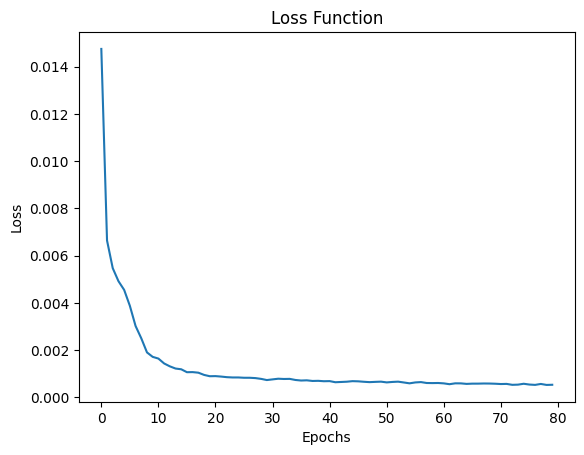

In [63]:
#After developing the model, the first thing we have to do is understand our loss function. We can plot it
plt.plot(range(len(Model.history.history['loss'])), Model.history.history['loss'])
plt.title('Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Again, we can see that after 40-50 epochs the model is having non-significant improvements. This can indicate that probably even 40, 50 epochs can be enough for this model

# Testing our model

For the multivariate it will be a bit more complicated than for the univariate.

As a reminder: in **univariate**, if we had WS=4 we will apply the model to t1, t2, t3, t4 and we will predict t5. Then, we will take t2, t3, t4, and the previously predicted t5 and we will predict t6. And so on, until the number of predictions we want to do.

In **multivariate** we don't have just target variables, as we have also other variables. What we do is the same thing but this time, for t5, we will bring the values of the external variables from our original data and we will bring the predicted value of t5 but just for our independent variable. Then, we will predict t6, and we will bring the values of the external variables from our original data and we will bring the predicted value of t6 but just for our independent variable. And so on, until the number of predictions we want to do.

In [70]:
#First, we start by creating an empty list
prediction_test = []

#Now, we create batch one, which contains the last WS observations from the training set
batch_one = training_set_scaled[-WS:]

#Then, we create a list for the new batches
batch_new = batch_one.reshape((1, WS, 3)) #We have a 3 because we have 3 input features

In [71]:
#Now, we create our for loop
for i in range(48): #Here we are predicting 48, which is the lenght of the test set. We could also expand the predictions to bigger numbers
    First_pred = Model.predict(batch_new)[0]
    prediction_test.append(First_pred)
    #Now we have to create a new variable. Which is our test_set_scaled. In the test_set_scaled, previously we removed the column to predict, so right now we just have the predictors. Then we say, get the row i of predictors and add them into New_var
    New_var = test_set_scaled[i,:]
    New_var = New_var.reshape(1,2) #We have a 2 because we have 2 input features
    New_test = np.insert(New_var, 2, [First_pred], axis=1) #Here, we have the 2 because we have 2 input features (columns 0 and 1) so we are saying, go to column 2 and insert the First_pred value
    New_test = np.reshape(New_test, (1,1,3))
    #Then, we have to update the batch_new
    batch_new = np.append(batch_new[:,1:,:], New_test, axis=1) #We are saying, go to batch_new, select all the rows, select columns from 1 to the end, and then add the New_test. We are doing this because we want to update the batch_new with the new prediction, so we have to remove the first value of the batch_new and add the new prediction

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


In [72]:
#Now, we transform the prediction_test into a numpy array
prediction_test = np.array(prediction_test)

In [73]:
#Now, we have to bring back the predictions into the original scale, not the scaled one. It has a small trick in comparison with the univariate case. We cannot use the inverse_transform method directly because we have used sc for 3 variables, but now we want to bring one. We can use it if we want to bring back all the variables, but not if we want to bring back just one.

SI = MinMaxScaler(feature_range=(0,1)) #We create a new scaler, with the same range as the previous one
#Now, we want the 3 column
y_scale = training_set[:,2:3] #We are saying, go to training_set, select all the rows, and select the column 3. We are selecting the 2 because we want the third column, and we have to start counting from 0
SI.fit(y_scale) #We fit the scaler with the y_scale

MinMaxScaler()

In [74]:
#The next thing is using our predictions with the inverse_transform method for the SI scaler that we have created and fit with the target variable
predictions = SI.inverse_transform(prediction_test)

In [75]:
predictions

array([[ 916.8212 ],
       [ 874.1394 ],
       [ 847.5091 ],
       [ 833.9819 ],
       [ 831.9097 ],
       [ 846.4926 ],
       [ 887.5891 ],
       [ 948.8053 ],
       [ 995.75946],
       [1008.17206],
       [ 998.91876],
       [ 992.67175],
       [ 998.893  ],
       [1013.0174 ],
       [1025.8729 ],
       [1035.6385 ],
       [1052.8254 ],
       [1111.5592 ],
       [1224.2833 ],
       [1265.5294 ],
       [1230.3729 ],
       [1190.168  ],
       [1139.0167 ],
       [1073.3346 ],
       [1001.90283],
       [ 939.5857 ],
       [ 896.1453 ],
       [ 869.8129 ],
       [ 855.1094 ],
       [ 848.1908 ],
       [ 852.0687 ],
       [ 875.62537],
       [ 923.51874],
       [ 984.5567 ],
       [1033.9121 ],
       [1067.3716 ],
       [1093.0162 ],
       [1105.8702 ],
       [1107.1451 ],
       [1103.6377 ],
       [1103.0776 ],
       [1115.8391 ],
       [1149.8091 ],
       [1178.7548 ],
       [1168.8921 ],
       [1139.9625 ],
       [1108.7101 ],
       [1064.

In [76]:
real_values = test_set[:,2]

In [77]:
real_values

array([ 941.,  923.,  913.,  905.,  923.,  964., 1038., 1096., 1111.,
       1094., 1049., 1082., 1077., 1070., 1085., 1148., 1241., 1335.,
       1296., 1269., 1232., 1171., 1114., 1020.,  987.,  952.,  931.,
        911.,  940.,  974., 1049., 1096., 1116., 1144., 1177., 1223.,
       1221., 1203., 1207., 1226., 1279., 1305., 1242., 1180., 1133.,
       1073.,  994.,  919.])

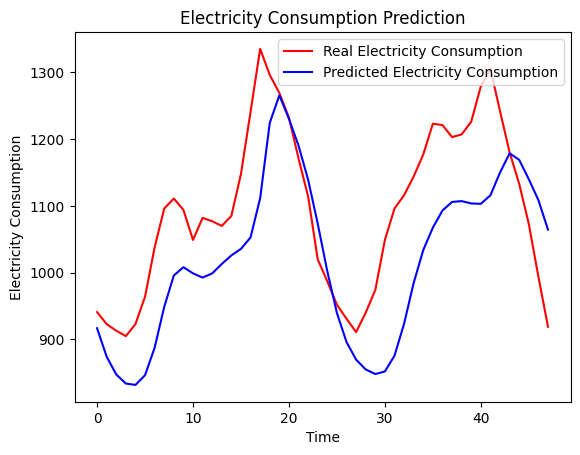

In [78]:
plt.plot(real_values, color='red', label='Real Electricity Consumption')
plt.plot(predictions, color='blue', label='Predicted Electricity Consumption')
plt.title('Electricity Consumption Prediction')
plt.xlabel('Time')
plt.ylabel('Electricity Consumption')
plt.legend()
plt.show()

In [79]:
#Now, we can calculate the RMSE
import math
from sklearn.metrics import mean_squared_error

RMSE = math.sqrt(mean_squared_error(real_values, predictions))
print('The RMSE is: ' + str(RMSE))

The RMSE is: 113.33487190742883


In [81]:
#Now, we define the MAPE function
def mean_absolute_percentage_error (y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [84]:
MAPE= mean_absolute_percentage_error(real_values, predictions)

print('The MAPE is: ' + str(MAPE) + '%')


The MAPE is: 13.684504007077402%
